In [59]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import networkx as nx
import pandas as pd
from itertools import combinations
import math

In [60]:
#G = nx.DiGraph()
data = pd.read_csv("City_Trees.csv",usecols=["SPECIES","Latitude","Longitude"])
data.dropna(inplace = True)
trees = data["SPECIES"].str.split(" ", n =1, expand = True)
data["genus"] = trees[0]
data["species"] = trees[1]
#data['ID'] = range(len(data))
data.drop(columns = ["SPECIES"], inplace= True)
data = data[data.genus != 'Planting']
data = data[data.species != 'Site']
data = data[data.species != ' species']

data = data.reset_index()
#data = data.transpose()
n_attr = len(data.index.values)
attr = data.index.values
data.drop(columns = ["index"], inplace= True)
data['id'] = np.arange(len(data))
data.head()

#small, poorly sampled group to run code on
data200 = data.iloc[:200]
data200.to_csv('data200.csv')
data.head()

,Latitude,Longitude,genus,species,id
0,37.884954,-122.278251,Prunus,cerasifera,0
1,37.884965,-122.278166,Liquidambar,styraciflua,1
2,37.884816,-122.277695,Prunus,cerasifera,2
3,37.884632,-122.277194,Aesculus,californica,3
4,37.884794,-122.275969,Platanus,hybrida,4


In [61]:
#take smaller area of data

lat_lon_bounds = {}

lat_lon_bounds['BL'] = (37.88005, -122.26978)
lat_lon_bounds['BR'] = (37.88134, -122.25939)
lat_lon_bounds['TL'] = (37.88547, -122.26999)
lat_lon_bounds['TR'] = (37.88672, -122.26042)



latitude = data['Latitude']
cleaned_lat = data[(latitude <= lat_lon_bounds['TR'][0]) & (latitude >= lat_lon_bounds["BL"][0])]

longitude = data['Longitude']

cleaned_data = cleaned_lat[(longitude <= lat_lon_bounds["BR"][1]) & (longitude >= lat_lon_bounds["TL"][1])]
cleaned_data = cleaned_data.reset_index()
cleaned_data.drop(columns = ["index"], inplace= True)
cleaned_data['id'] = np.arange(len(cleaned_data))

cleaned_data

C:\Users\omeed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Latitude,Longitude,genus,species,id
0,37.881406,-122.269948,Ginkgo,biloba,0
1,37.881301,-122.269876,Ginkgo,biloba,1
2,37.881092,-122.269708,Ginkgo,biloba,2
3,37.881012,-122.269623,Ginkgo,biloba,3
4,37.880920,-122.269599,Ginkgo,biloba,4
...,...,...,...,...,...
837,37.883839,-122.269426,Ulmus,americana,837
838,37.883801,-122.269456,Quercus,agrifolia,838
839,37.883720,-122.269502,Pistacia,chinensis,839
840,37.883673,-122.269631,Pistacia,chinensis,840


In [39]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

def calc_dist(node_tuple):
    first_node = node_tuple[0]
    second_node = node_tuple[1]
    return haversine(cleaned_data.iloc[first_node][0:2], cleaned_data.iloc[second_node][0:2])

def calc_weight(node_tuple):
    #returns firstly, the weight, secondly, the calculated distance, 
    #and lastly, 2 if different genus+species, 1 if different species but same genus
    outer_ring_threshold = 1000
    inner_ring_threshold = 500
    
    
    dist = calc_dist(node_tuple)
    first_node = node_tuple[0]
    second_node = node_tuple[1]
    genus1 = cleaned_data.iloc[first_node][2]
    species1 = cleaned_data.iloc[first_node][3]
    genus2 = cleaned_data.iloc[second_node][2]
    species2 = cleaned_data.iloc[second_node][3]
    
    if dist < inner_ring_threshold: 
        if genus1 != genus2:
            return 4, dist, 2
        elif species1 != species2:
            return 3, dist, 1
        else: 
            return 0, 0, 0
    elif dist < outer_ring_threshold: 
        if genus1 != genus2:
            return 2, dist, 2
        elif species1 != species2:
            return 1, dist, 1
        else: 
            return 0, 0, 0 
    else: 
        return 0, 0, 0

In [42]:
links = []

for comb_of_2_plant_ids in combinations(cleaned_data['id'], 2):
    weight, dist, dif_genus_species = calc_weight(comb_of_2_plant_ids)
    if weight != 0:
        links.append([comb_of_2_plant_ids[0], comb_of_2_plant_ids[1], weight, dist, dif_genus_species])
        
links = np.array(links)

print(links)
print(len(links))

KeyboardInterrupt: 

In [41]:
edges = pd.DataFrame({"first_node": links[:,0], 
                      "second_node": links[:,1], 
                      "weight": links[:,2],
                      "dist": links[:,3],
                      "dif_genus_species": links[:,4]})
edges.to_csv('1000_500_edges.csv')
print(edges.shape)
edges.head()

TypeError: list indices must be integers or slices, not tuple

In [62]:
edges = pd.read_csv("1000_500_edges.csv")

In [63]:
G = nx.Graph()

In [64]:
for index, row in edges.iterrows():
    G.add_edge(row['first_node'], row['second_node'], weight=row['weight'])

In [65]:
filtered_data = cleaned_data[cleaned_data['id'].isin(list(G.nodes()))]

In [66]:
filtered_data

,Latitude,Longitude,genus,species,id
0,37.881406,-122.269948,Ginkgo,biloba,0
1,37.881301,-122.269876,Ginkgo,biloba,1
2,37.881092,-122.269708,Ginkgo,biloba,2
3,37.881012,-122.269623,Ginkgo,biloba,3
4,37.880920,-122.269599,Ginkgo,biloba,4
...,...,...,...,...,...
837,37.883839,-122.269426,Ulmus,americana,837
838,37.883801,-122.269456,Quercus,agrifolia,838
839,37.883720,-122.269502,Pistacia,chinensis,839
840,37.883673,-122.269631,Pistacia,chinensis,840


In [73]:
weight_list = []
for node in sorted(list(G.nodes())):
    #print ("Degree of ", node, " are : ", G.degree(node))
    weight_list.append(G.degree(node,weight='weight'))


In [74]:
filtered_data['degree'] = weight_list

In [75]:
filtered_data

,Latitude,Longitude,genus,species,id,degree
0,37.881406,-122.269948,Ginkgo,biloba,0,2234.0
1,37.881301,-122.269876,Ginkgo,biloba,1,2222.0
2,37.881092,-122.269708,Ginkgo,biloba,2,2218.0
3,37.881012,-122.269623,Ginkgo,biloba,3,2218.0
4,37.880920,-122.269599,Ginkgo,biloba,4,2212.0
...,...,...,...,...,...,...
837,37.883839,-122.269426,Ulmus,americana,837,2596.0
838,37.883801,-122.269456,Quercus,agrifolia,838,2262.0
839,37.883720,-122.269502,Pistacia,chinensis,839,2458.0
840,37.883673,-122.269631,Pistacia,chinensis,840,2442.0


In [76]:
total_degree_by_genus = filtered_data.groupby('genus')['degree'].sum().sort_values(ascending=False)

In [77]:
avg_degree_by_genus = filtered_data.groupby('genus')['degree'].mean().sort_values(ascending=False)

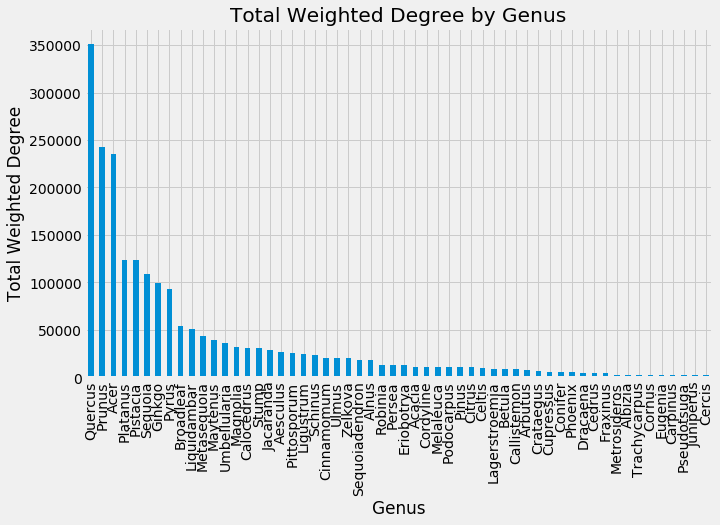

In [80]:
plt.figure(figsize=(10, 6))
total_degree_by_genus.plot(kind='bar')
plt.title("Total Weighted Degree by Genus")
plt.ylabel("Total Weighted Degree")
plt.xlabel("Genus")
plt.show()

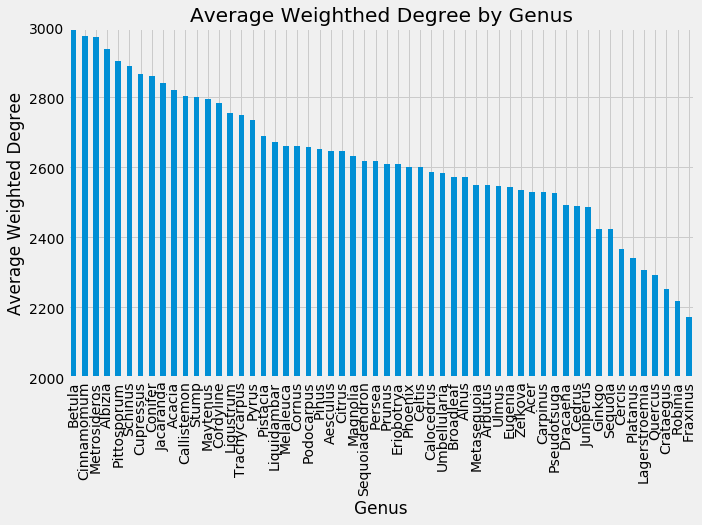

In [83]:
plt.figure(figsize=(10, 6))
avg_degree_by_genus.plot(kind='bar')
plt.title("Average Weighthed Degree by Genus")
plt.ylabel("Average Weighted Degree")
plt.xlabel("Genus")
plt.ylim((2000,3000))
plt.show()

In [84]:
filtered_data

,Latitude,Longitude,genus,species,id,degree
0,37.881406,-122.269948,Ginkgo,biloba,0,2234.0
1,37.881301,-122.269876,Ginkgo,biloba,1,2222.0
2,37.881092,-122.269708,Ginkgo,biloba,2,2218.0
3,37.881012,-122.269623,Ginkgo,biloba,3,2218.0
4,37.880920,-122.269599,Ginkgo,biloba,4,2212.0
...,...,...,...,...,...,...
837,37.883839,-122.269426,Ulmus,americana,837,2596.0
838,37.883801,-122.269456,Quercus,agrifolia,838,2262.0
839,37.883720,-122.269502,Pistacia,chinensis,839,2458.0
840,37.883673,-122.269631,Pistacia,chinensis,840,2442.0


In [85]:
lat_lon_dict = {}
for index, row in filtered_data.iterrows():
    node=row[4]
    lat=row[0]
    lon=row[1]
    lat_lon_dict[node] = (lon,lat)

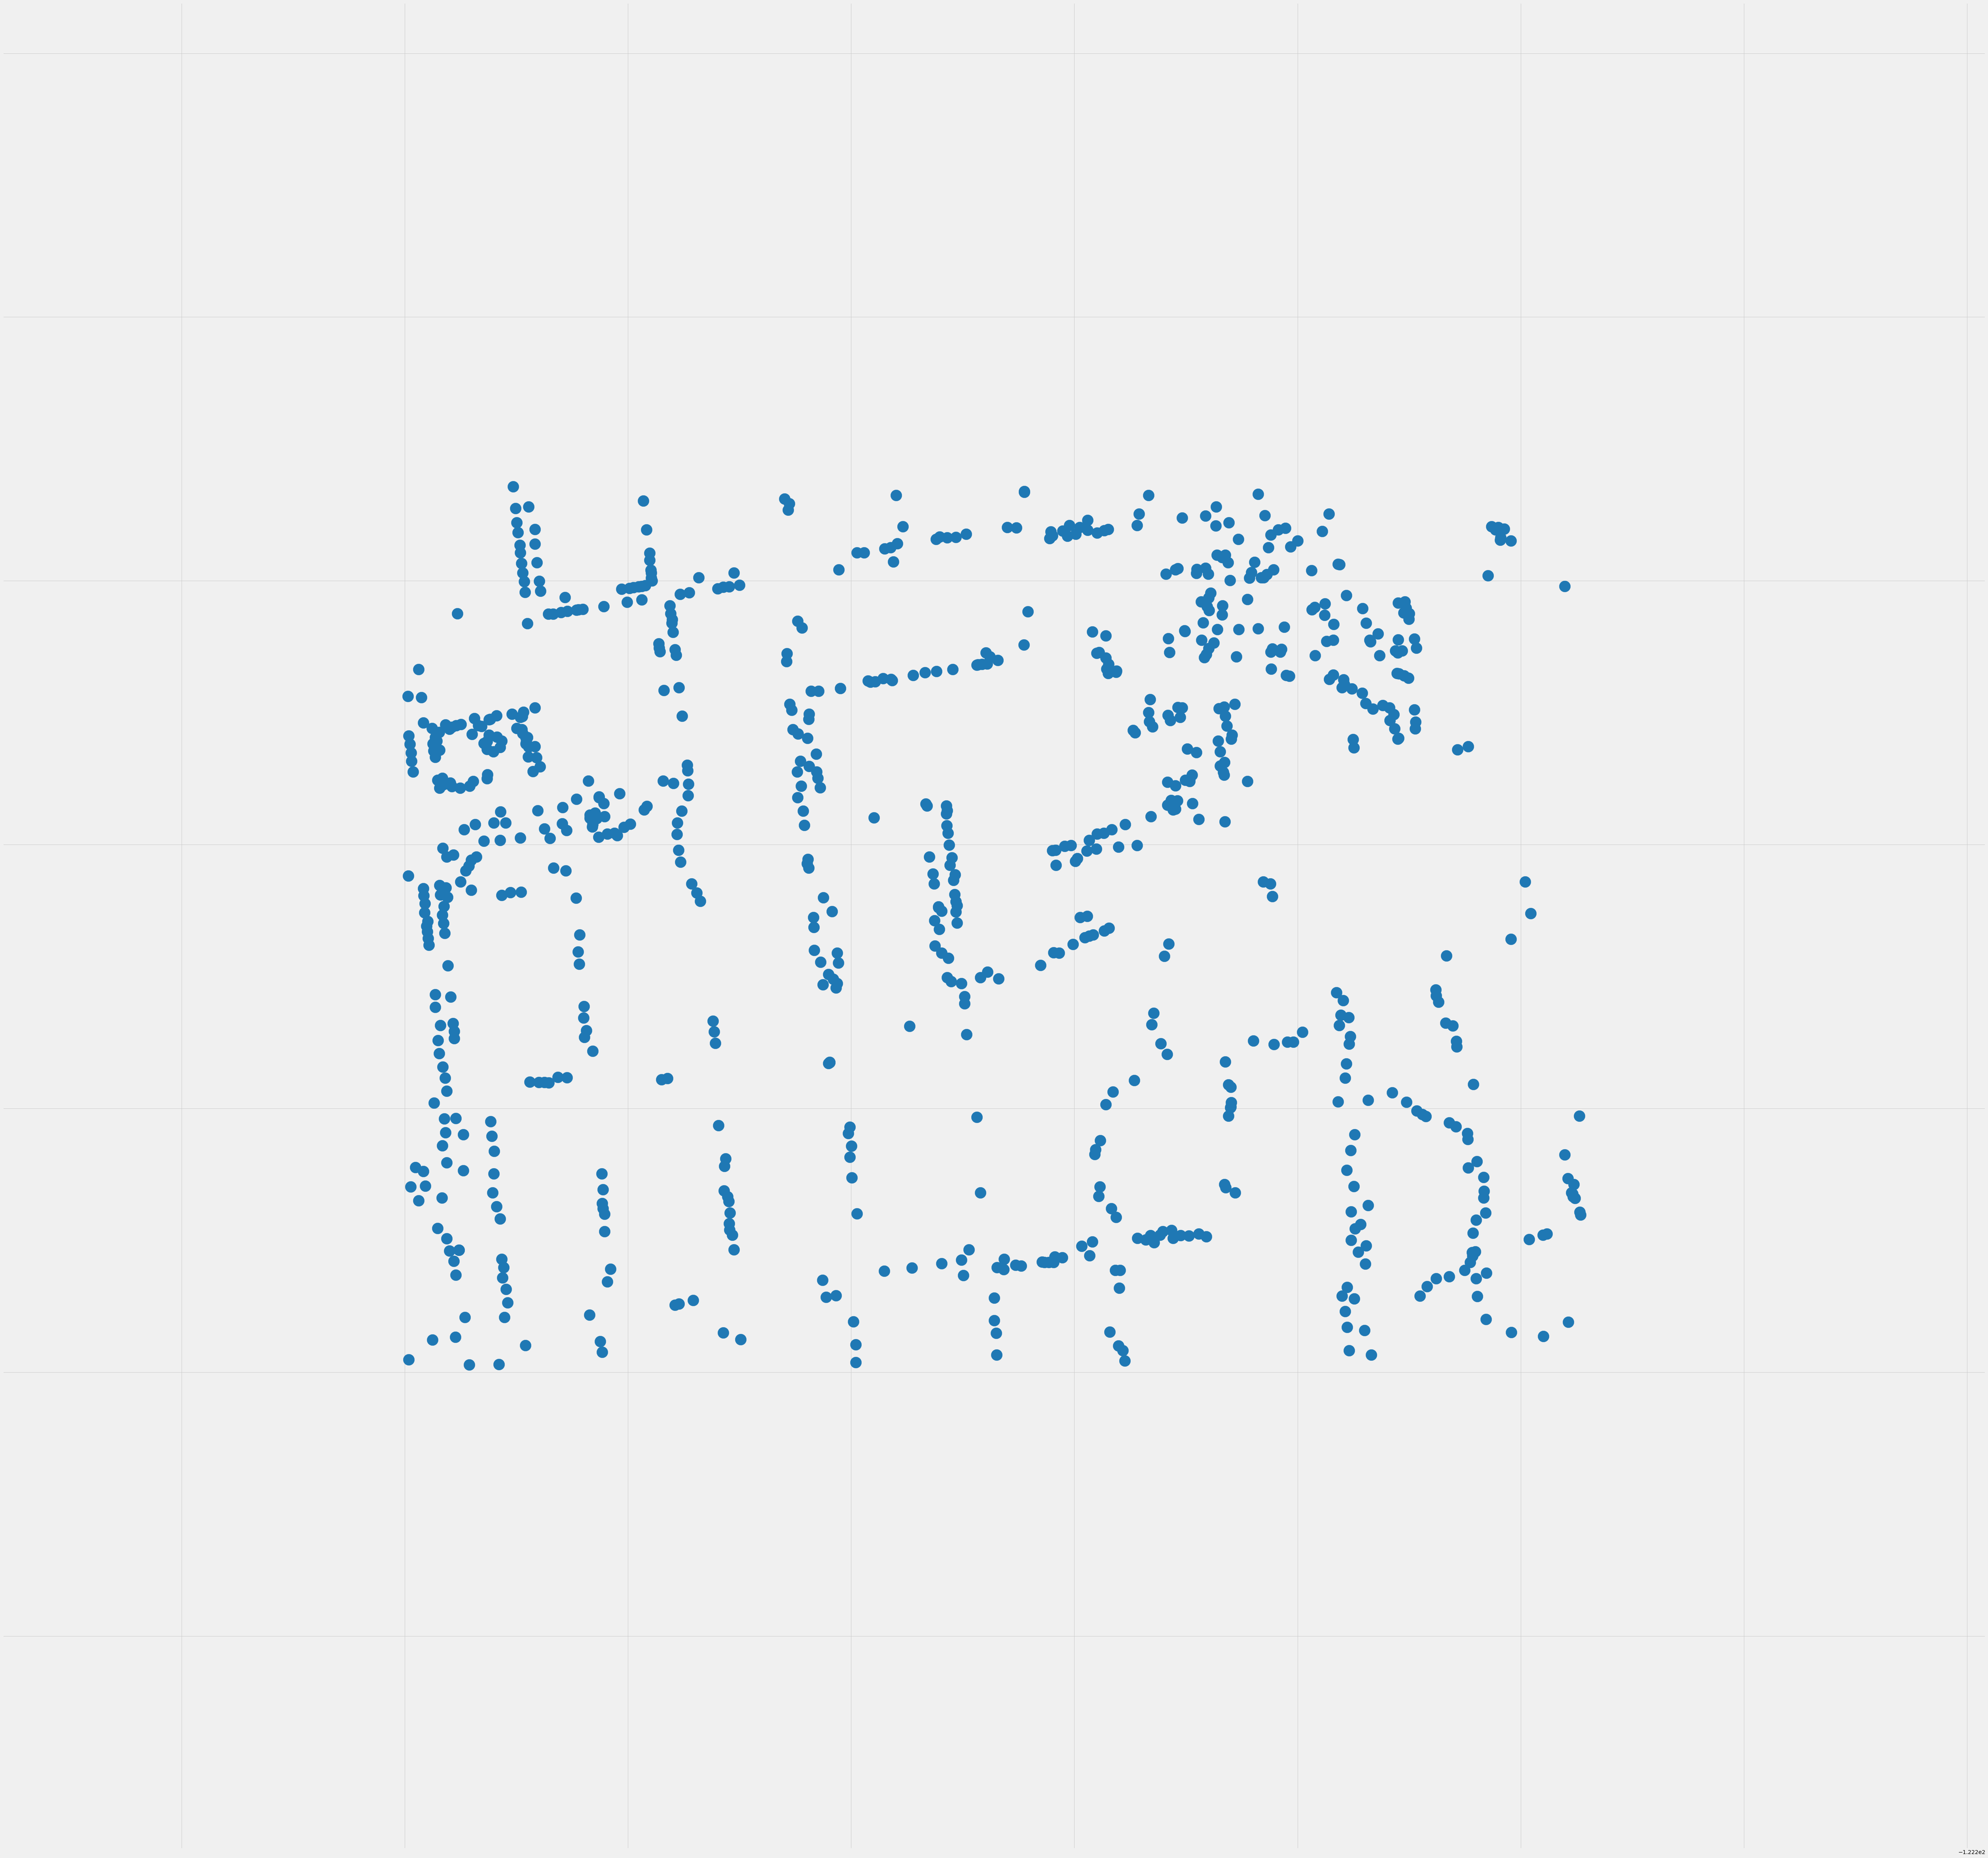

In [86]:
plt.figure(figsize=(80,80))
nx.draw_networkx_nodes(G,lat_lon_dict, node_size=800)          
plt.show()

In [87]:
close_centrality = list(nx.closeness_centrality(G).values())

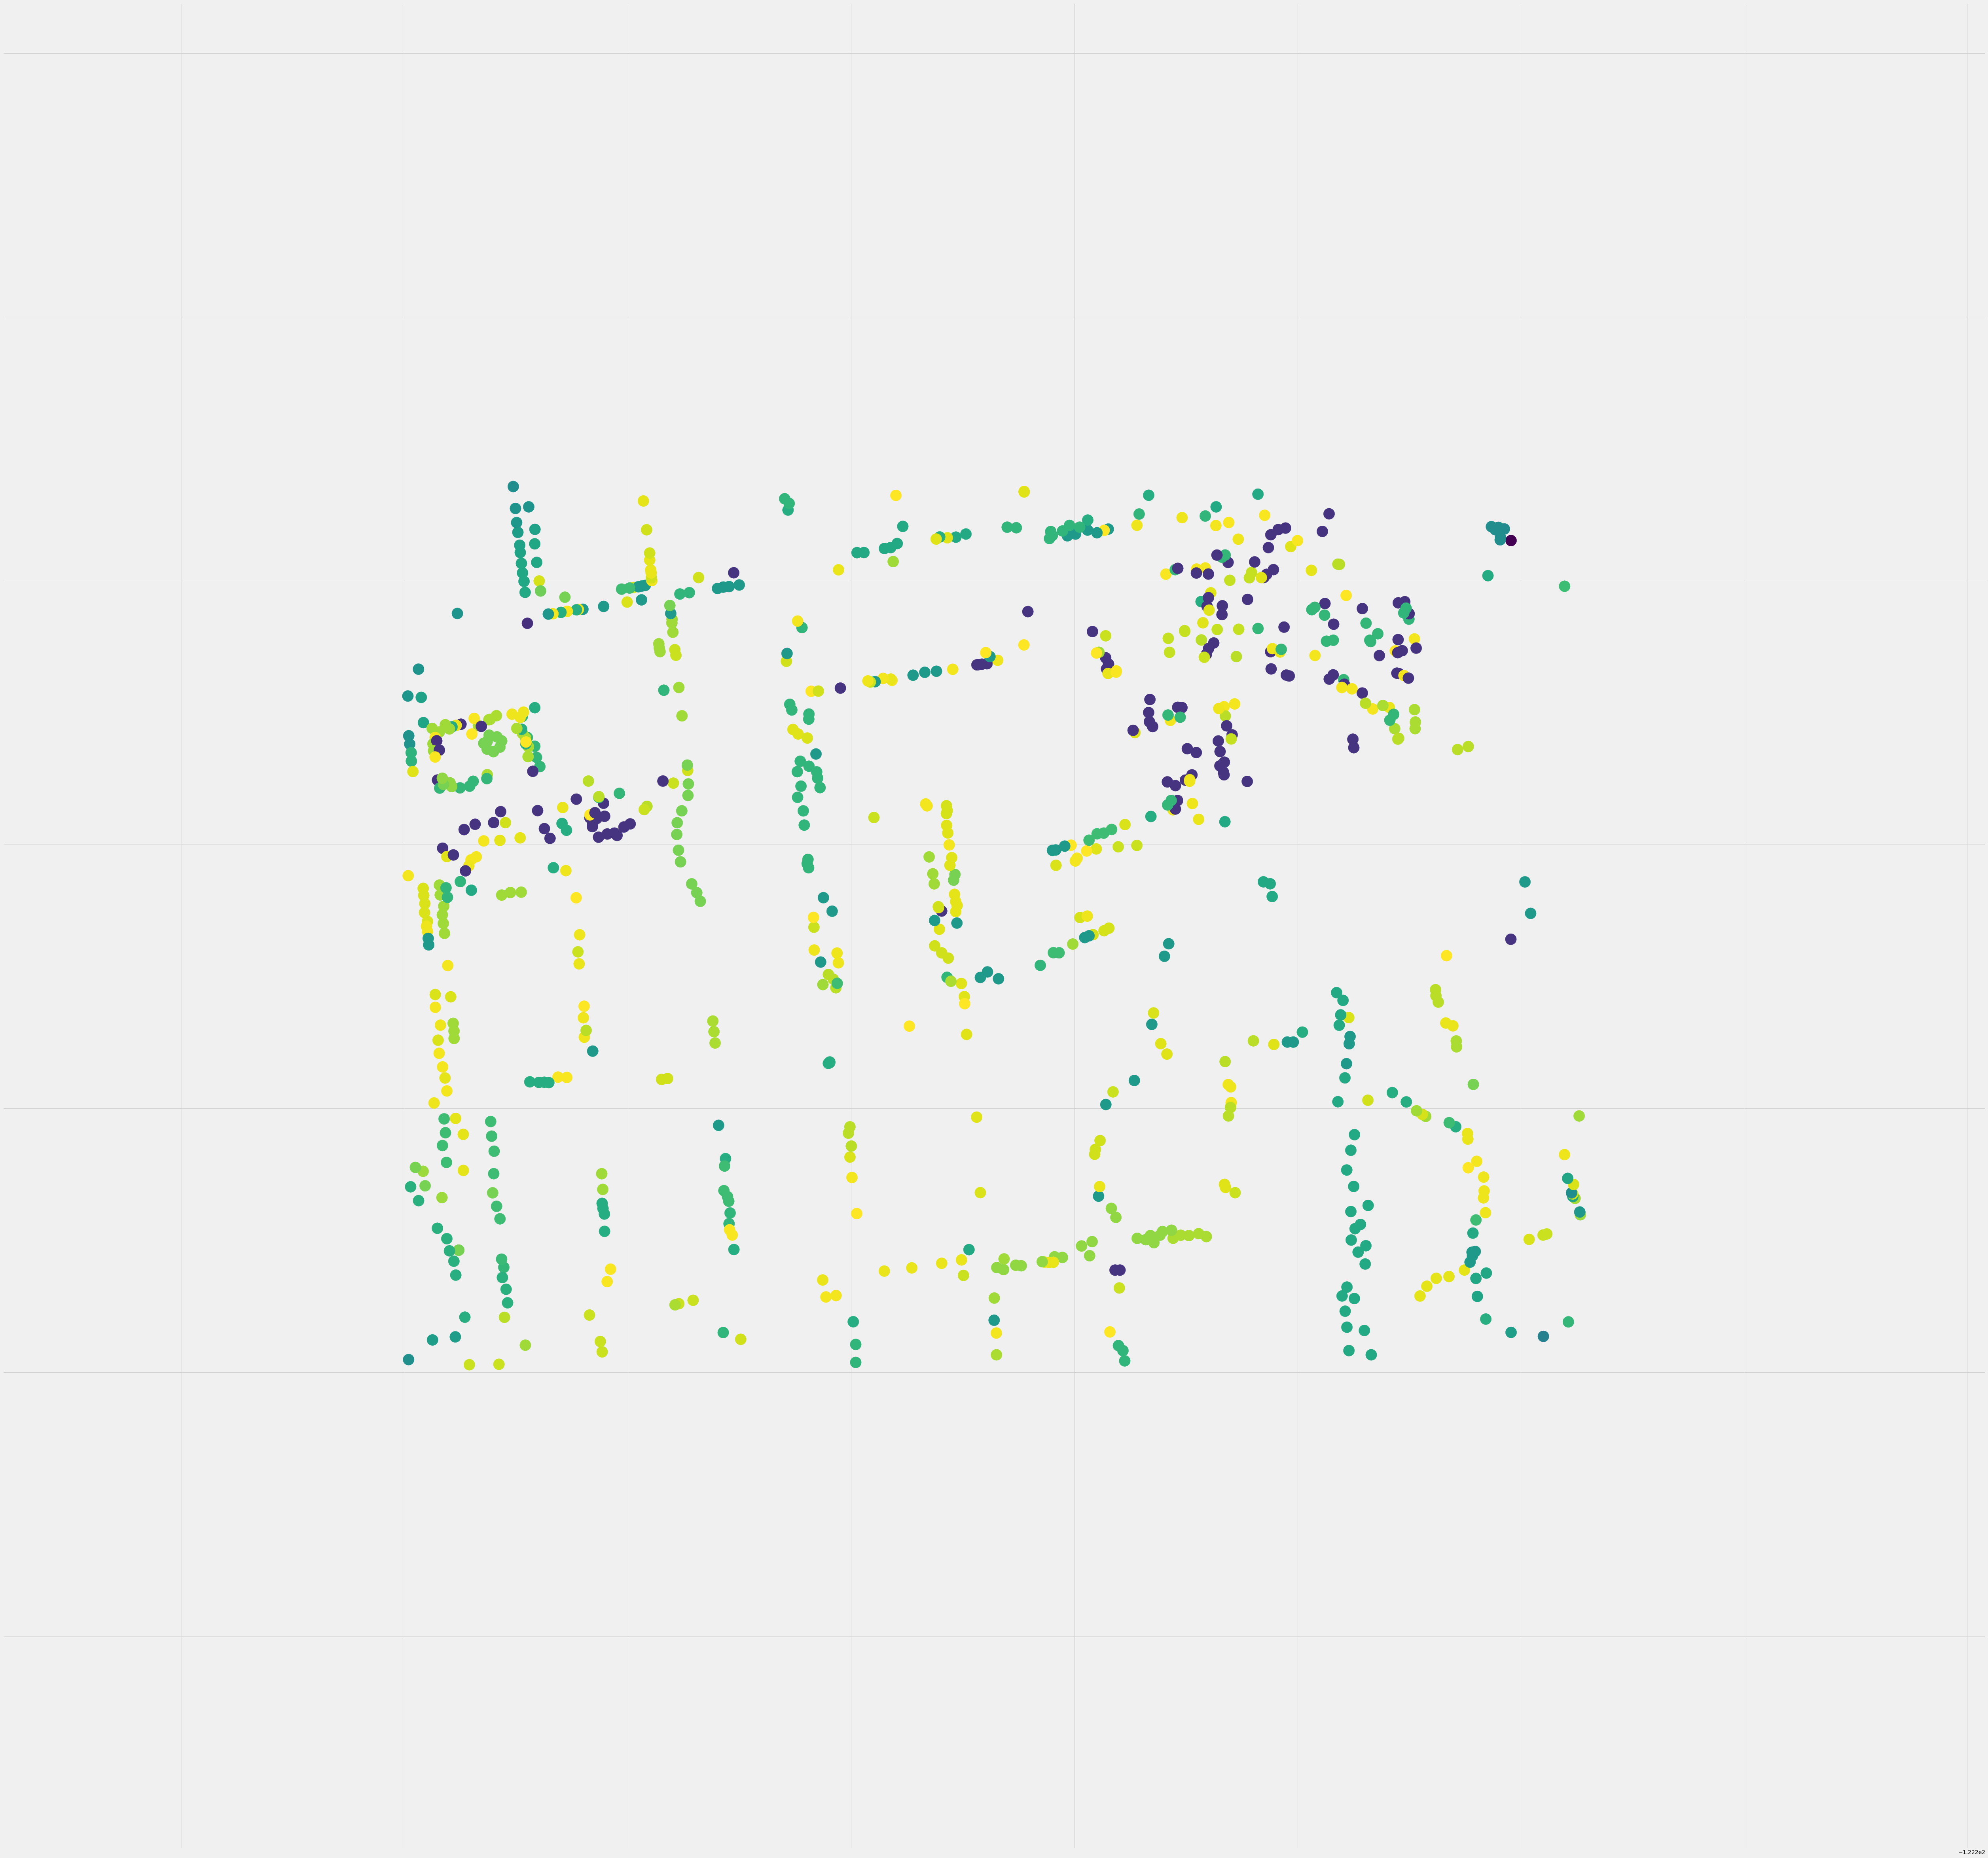

In [88]:
plt.figure(figsize=(80,80))
nx.draw_networkx_nodes(G,lat_lon_dict, node_size=800,node_color=close_centrality)          
plt.show()